# Actor-Critic Methods

---

In this notebook, we will train Actor-Critic Methods with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from itertools import count
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import pickle

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### 2. Define the Environment

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)
torch.manual_seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


In [4]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
GAMMA = 0.99
LOG_INTERVAL = 100

### 3. Defien Actor-Critic Model (Shared Network)

In [5]:
class AC_Model(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(AC_Model, self).__init__()
        self.affine1 = nn.Linear(4, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 2)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values

### 4. Train the Agent with AC Model

In [6]:
ac_model = AC_Model()
optimizer = optim.Adam(ac_model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()

In [7]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = ac_model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    ac_model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (left or right)
    return action.item()


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = ac_model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    # discounted rewards
    for r in ac_model.rewards[::-1]:
        # calculate the discounted value
        R = r + GAMMA * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del ac_model.rewards[:]
    del ac_model.saved_actions[:]

In [8]:
def run_actor_critic():

    running_reward = 10
    scores = []

    # run inifinitely many episodes
    for i_episode in count(1):

        # reset environment and episode reward
        state = env.reset()
        ep_reward = 0

        # for each episode, only run 9999 steps so that we don't 
        # infinite loop while learning
        for t in range(1, 10000):

            # select action from policy
            action = select_action(state)

            # take the action
            state, reward, done, _ = env.step(action)

            ac_model.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        scores.append(ep_reward)
        torch.save(ac_model.state_dict(), 'ac_model_checkpoint.pth')

        # update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        # perform backprop
        finish_episode()

        # log results
        if i_episode % LOG_INTERVAL == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))

        # check if we have "solved" the cart pole problem
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break
    
    return scores

scores_1 = run_actor_critic()

Episode 100	Last reward: 9.00	Average reward: 9.65
Episode 200	Last reward: 9.00	Average reward: 9.37
Episode 300	Last reward: 9.00	Average reward: 9.36
Episode 400	Last reward: 10.00	Average reward: 9.32
Episode 500	Last reward: 10.00	Average reward: 9.38
Episode 600	Last reward: 10.00	Average reward: 9.28
Episode 700	Last reward: 12.00	Average reward: 9.78
Episode 800	Last reward: 108.00	Average reward: 73.51
Episode 900	Last reward: 19.00	Average reward: 115.88
Episode 1000	Last reward: 28.00	Average reward: 29.47
Episode 1100	Last reward: 91.00	Average reward: 48.31
Episode 1200	Last reward: 74.00	Average reward: 68.24
Episode 1300	Last reward: 84.00	Average reward: 142.46
Episode 1400	Last reward: 111.00	Average reward: 127.54
Solved! Running reward is now 195.15692562173936 and the last episode runs to 200 time steps!


In [10]:
with open('./ac_model_scores.pkl', 'wb') as f:
    pickle.dump(scores_1,f)

### 6. Defien Actor-Critic Model (Seperated Network)

In [11]:
class Actor(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Actor, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)

        self.saved_actions = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        action_prob = F.softmax(self.action_head(x), dim=-1)
        return action_prob
    
class Critic(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Critic, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.value_head = nn.Linear(128, 1)

        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        state_values = self.value_head(x)
        return state_values

In [12]:
actor = Actor()
critic = Critic()

a_optimizer = optim.Adam(actor.parameters(), lr=3e-2)
c_optimizer = optim.Adam(critic.parameters(), lr=3e-2)

eps = np.finfo(np.float32).eps.item()

In [13]:
def select_action_sep_model(state):
    state = torch.from_numpy(state).float()
    action_probs = actor(state)
    q_value = critic(state)

    m = Categorical(action_probs)
    action = m.sample()

    actor.saved_actions.append(SavedAction(m.log_prob(action), q_value))
    return action.item()


def finish_episode_sep_model():
    R = 0
    saved_actions = actor.saved_actions
    policy_losses = []
    value_losses = []
    returns = []

    for r in critic.rewards[::-1]:
        R = r + GAMMA * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, q_value), R in zip(saved_actions, returns):
        advantage = R - q_value.item()
        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(q_value, torch.tensor([R])))

    a_optimizer.zero_grad()
    c_optimizer.zero_grad()
    
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss.backward()
    
    a_optimizer.step()
    c_optimizer.step()

    del critic.rewards[:]
    del actor.saved_actions[:]

In [14]:
def run_actor_critic_2():
    running_reward = 10
    scores = []

    for i_episode in count(1):
        state = env.reset()
        ep_reward = 0
        for t in range(1, 10000):
            action = select_action_sep_model(state)
            state, reward, done, _ = env.step(action)
            critic.rewards.append(reward)
            ep_reward += reward
            if done:
                break
                
        scores.append(ep_reward)
        torch.save(actor.state_dict(), 'actor_checkpoint.pth')
        torch.save(critic.state_dict(), 'critic_checkpoint.pth')

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode_sep_model()

        if i_episode % LOG_INTERVAL == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))

        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break
            
    return scores

scores_2 = run_actor_critic_2()

Episode 100	Last reward: 120.00	Average reward: 47.62
Episode 200	Last reward: 141.00	Average reward: 152.07
Episode 300	Last reward: 176.00	Average reward: 157.38
Solved! Running reward is now 195.0079535123769 and the last episode runs to 200 time steps!


In [15]:
with open('./ac_model_scores_2.pkl', 'wb') as f:
    pickle.dump(scores_2, f)

### 7. Plot the Scores

In [21]:
# score_name = 'ac_model_scores.pkl'
score_name = 'ac_model_scores_2.pkl'

with open('./%s' % score_name, 'rb') as f:
    scores = pickle.load(f)
    
# ac_model = AC_Model()
# ac_model.load_state_dict(torch.load('./ac_model_checkpoint.pth'))

actor = Actor()
actor.load_state_dict(torch.load('./actor_checkpoint.pth'))
critic = Critic()
critic.load_state_dict(torch.load('./critic_checkpoint.pth'))

<All keys matched successfully>

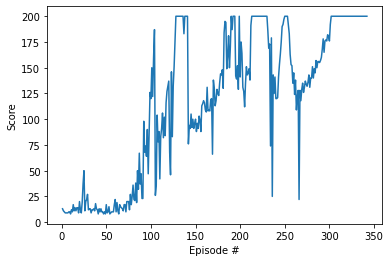

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Watch a Agent

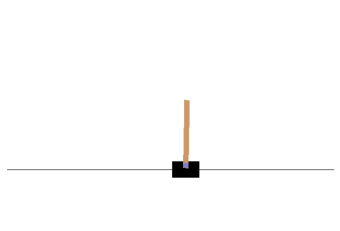

In [23]:
show_env2 = gym.make('CartPole-v0')
state = show_env2.reset()
img = plt.imshow(show_env2.render(mode='rgb_array'))
for t in range(10000):
    action = select_action_sep_model(state)
    img.set_data(show_env2.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = show_env2.step(action)
    if done:
        break 

show_env2.close()

In [25]:
state[None, :]

array([[ 0.22183912,  0.03967085,  0.02450126, -0.05195212]])